In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

Load the files from drive.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#load data
csv_path = '/content/drive/MyDrive/Drug_sales/train_data.csv'

In [3]:
df = pd.read_csv(csv_path)
# slice [start:stop:step], starting from left index every right indexth record.
df = df[1::200] # THis sentence is in case you want to not take the whole data or collect data over a period.

df.head()

,year,month,day,city,medicine,sales
1,2015,1,2,1,2,144.0
201,2015,1,2,1,202,40.0
401,2015,1,2,1,402,32.0
601,2015,1,2,1,602,33.9
801,2015,1,2,1,802,4.0


In [4]:
import datetime
## I created datetime object to play with frequency. However it is not needed here. Hence commented.
#date_time = pd.to_datetime(df[['year','month','day']])
#df['Date'] = date_time
print(df.head())

df['sales'] = df['sales'].clip(upper=2500) 
# In the training set there are some outliers which may reduce the performance of the model, because outliers meaning is not usual case. 
#Hence the data is slipped above 2500 for this dataset


     year  month  day  city  medicine  sales
1    2015      1    2     1         2  144.0
201  2015      1    2     1       202   40.0
401  2015      1    2     1       402   32.0
601  2015      1    2     1       602   33.9
801  2015      1    2     1       802    4.0


#The time-frequency plot between each feature and sales would show the frequency at which they affect the sales. As expected for year as the data is for 2015, 2016, 2017 and 2018, hence at those instances the color is warmer than anywhere else in the plot.

Text(0, 0.5, 'sales')

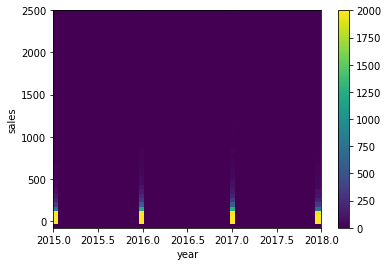

In [5]:
plt.hist2d(df['year'], df['sales'], bins=(50, 50), vmax=2000)
plt.colorbar()
plt.xlabel('year')
plt.ylabel('sales')

#Similarly for months, as months are from 1-12, the color is warmer in those regions.

Text(0, 0.5, 'sales')

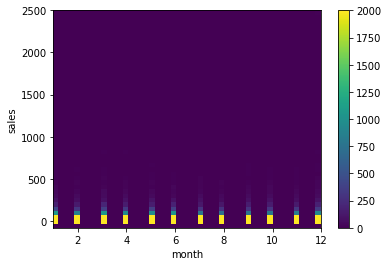

In [6]:
plt.hist2d(df['month'], df['sales'], bins=(50, 50), vmax=2000)
plt.colorbar()
plt.xlabel('month')
plt.ylabel('sales')

#For days, a pattern is visible. Two consecutive days followed by a gap and then one day. However during the last days of the month the pattern changes. However it could also suggest that as some of the months are of 30 or 28 days, it might suggest an usual pattern as year and month. 

Text(0, 0.5, 'sales')

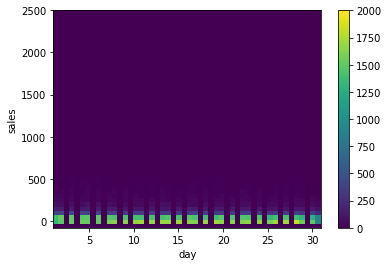

In [7]:
plt.hist2d(df['day'], df['sales'], bins=(50, 50), vmax=2000)
plt.colorbar()
plt.xlabel('day')
plt.ylabel('sales')

# In the medicine vs sales time-frequency plot,it can be seen that the region to impact the sales the highest is between 0-2500. This was the reason behind the clipping of data.

Text(0, 0.5, 'sales')

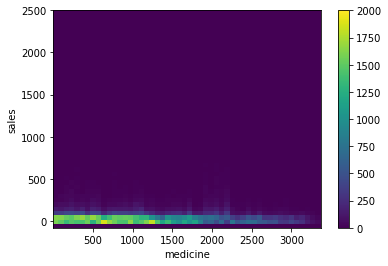

In [8]:
plt.hist2d(df['medicine'], df['sales'], bins=(50, 50), vmax=2000)
plt.colorbar()
plt.xlabel('medicine')
plt.ylabel('sales')

Text(0, 0.5, 'sales')

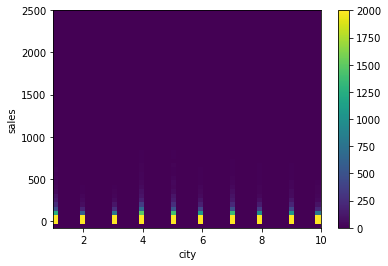

In [9]:
plt.hist2d(df['city'], df['sales'], bins=(50, 50), vmax=2000)
plt.colorbar()
plt.xlabel('city')
plt.ylabel('sales')

In [10]:
df.head()

,year,month,day,city,medicine,sales
1,2015,1,2,1,2,144.0
201,2015,1,2,1,202,40.0
401,2015,1,2,1,402,32.0
601,2015,1,2,1,602,33.9
801,2015,1,2,1,802,4.0


#To learn more on the dependence of sales on frequency component , we calculated FFT of the signal and checked the magnitude of the FFT. However we did not find any relationship between the frequency and sales.

In [ ]:
fft = tf.signal.rfft(df['sales'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['sales'])
days_per_year = 365.2524
days_per_month = 365.2524/12
years_per_dataset = n_samples_h/(days_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 100000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524/12, 365.2524], labels=['1/Year', '1/month', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

#Now that we have checked the relationship between different features, it is time to prepare the data for building model.

##1.Splitting Data into training, validation and test dataset at 70:20:10 ratio of the total training data.

In [11]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

##2. Normalization of splitted datasets.
  The year values are in thousands whereas month varies from 1-12 while day varies from 1-31 and medicine from zero to thousands. High variation in the dataset may cause the model to not converge. Hence Normalization was needed.
  There are many ways of normalizing the data. One is to subtract DC offset from the data and dividing standard deviation of whole training Dataset. However as year value contains only 4 unique values and in test dataset only single type of year value would be there, in that case this method can cause the year values to be Nans. 
  As Normalization meaning is to scale the data between certain limit, generally 0-1, dividing maximum would achieve the same.

In [12]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df) / train_df.max()
val_df = (val_df) / train_df.max()
test_df = (test_df) / train_df.max()

#train_df = (train_df - train_mean) / train_std
#val_df = (val_df - train_mean) / train_std
#test_df = (test_df - train_mean) / train_std

## In time-series forecasting windowing is important to make predictions based on consecutive pair of features and labels. Different performance of model can be achieved based on the length of window and model used. Hence we are going to use different varieties of windows (wide, narrow, signle-step and multi-step). 

In [13]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Set the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [14]:
w1 = WindowGenerator(input_width=31, label_width=1, shift=1,
                     label_columns=['sales'])
w1

Total window size: 32
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30]
Label indices: [31]
Label column name(s): ['sales']

In [15]:
w2 = WindowGenerator(input_width=10, label_width=1, shift=1,
                     label_columns=['sales'])
w2

Total window size: 11
Input indices: [0 1 2 3 4 5 6 7 8 9]
Label indices: [10]
Label column name(s): ['sales']

In [16]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually which makes it easier to make the dataset.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [17]:

# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 11, 6)
Inputs shape: (3, 10, 6)
labels shape: (3, 1, 1)


In [18]:
w2.example = example_inputs, example_labels

In [19]:
def plot(self, model=None, plot_col='sales', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='*', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('days')

WindowGenerator.plot = plot

In [ ]:
w2.plot()

# Built a dataset from the windows generated through make_dataset function.

In [20]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=30)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [21]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [22]:
# Each element is an (inputs, label) pair
w2.train.element_spec

(TensorSpec(shape=(None, 10, 6), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [23]:
MAX_EPOCHS = 2

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.keras.metrics.RootMeanSquaredError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

##Baseline Model:

In [24]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

#Baseline model using single step window: The model made to predict immediate short length based on current data.
#Baseline model is necessary to test the performance of the base model i.e., simplest model to improve further and compare other models w.r.t the baseline model. Accordingly whichever model performs the best, would be selected to be used with the test.csv data. 

Use of linear model applies linear transform between input and output. Below implemented is one of the linear model implemented.

Evaluation of the performance of the model based on the metrics set in the model.compile was conducted above and shown below.

##Multi-output models

In [25]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=31, label_width=31, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (30, 31, 6)
Labels shape (batch, time, features): (30, 31, 6)


In [26]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.RootMeanSquaredError()])

#Dense model. In this model change in number of units can change the performance of the model.

In [27]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [28]:
history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()

val_performance = {}
performance = {}

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=2)

755/755 [==============================] - 2s 3ms/step - loss: 0.4161 - root_mean_squared_error: 0.6451
378/378 - 1s - loss: 0.3647 - root_mean_squared_error: 0.6039


In [29]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each timestep is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [30]:
%%time
wide_window = WindowGenerator(
    input_width=31, label_width=31, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(64, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

print()

754/754 [==============================] - 3s 4ms/step - loss: 0.5891 - root_mean_squared_error: 0.7676

CPU times: user 1min 4s, sys: 13.6 s, total: 1min 18s
Wall time: 39.1 s


In [31]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small
        # So initialize the output layer with zeros
        kernel_initializer=tf.initializers.zeros)
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)
print()

754/754 [==============================] - 3s 4ms/step - loss: 0.5315 - root_mean_squared_error: 0.7290

CPU times: user 1min 3s, sys: 13.6 s, total: 1min 17s
Wall time: 38.2 s


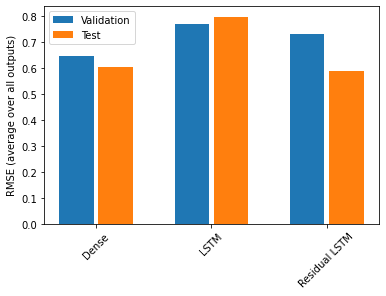

In [32]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'root_mean_squared_error'
metric_index = lstm_model.metrics_names.index('root_mean_squared_error')
val_rmse = [v[metric_index] for v in val_performance.values()]
test_rmse = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_rmse, width, label='Validation')
plt.bar(x + 0.17, test_rmse, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('RMSE (average over all outputs)')
_ = plt.legend()

This shows that Residual LSTM performed better than LSTM. However the RMSE was not very different between Dense and Residual LSTM. 

In [33]:
for name, value in performance.items():
  print(f'{name:15s}: {value[1]:0.4f}')

Dense          : 0.6039
LSTM           : 0.7960
Residual LSTM  : 0.5866


Total window size: 62
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30]
Label indices: [31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54
 55 56 57 58 59 60 61]
Label column name(s): None

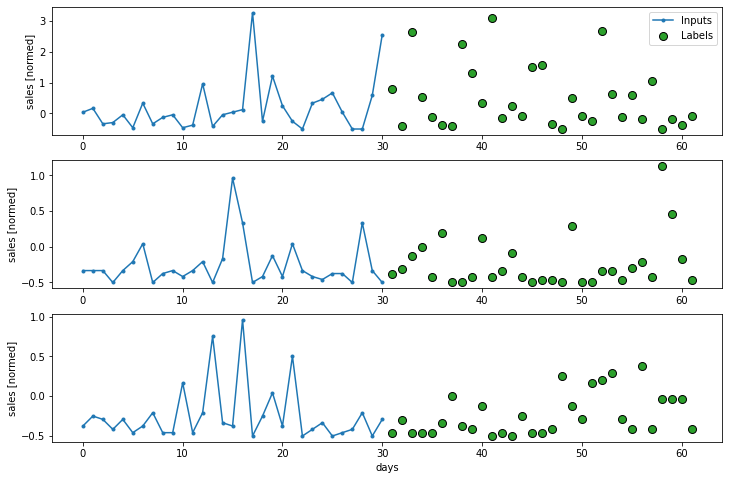

In [34]:
OUT_STEPS = 31
multi_window = WindowGenerator(input_width=31,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

##Multistep Last Baseline:

753/753 [==============================] - 2s 3ms/step - loss: 1.2636 - root_mean_squared_error: 1.1241


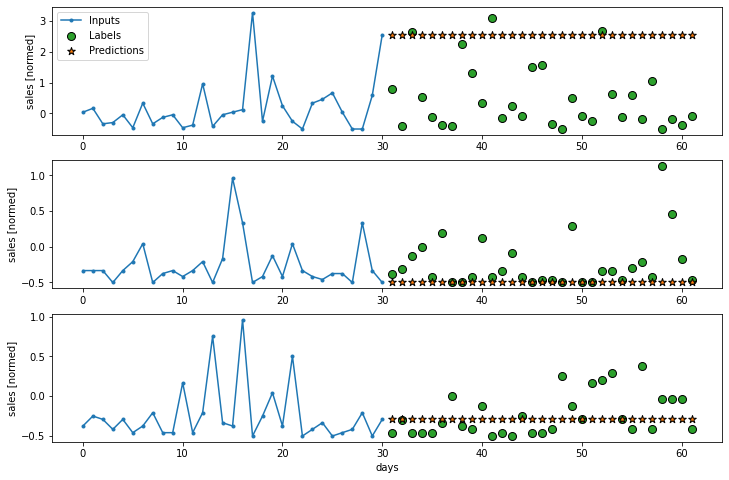

In [35]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.keras.metrics.RootMeanSquaredError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

753/753 [==============================] - 2s 3ms/step - loss: 1.6480 - root_mean_squared_error: 1.2838


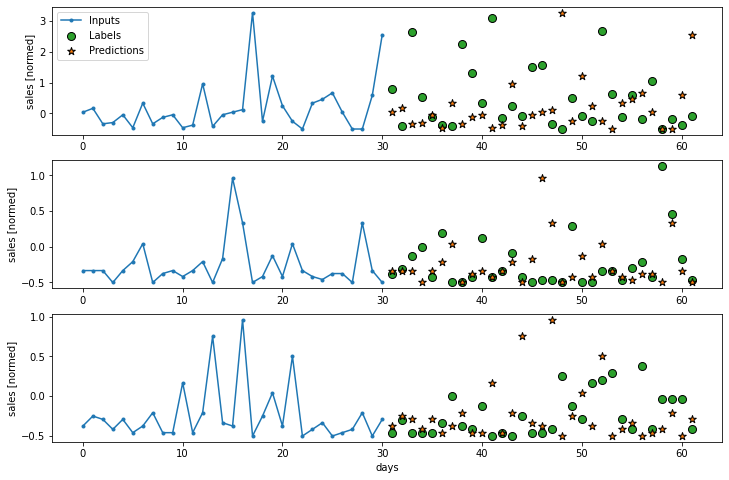

In [36]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.keras.metrics.RootMeanSquaredError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

Repeat baseline clearly shows better prediction than that of the previous two baselines.

753/753 [==============================] - 2s 3ms/step - loss: 0.6632 - root_mean_squared_error: 0.8144


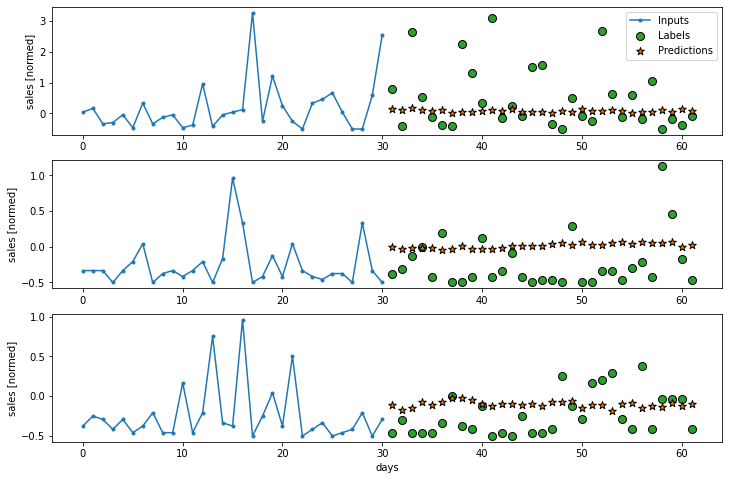

In [37]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

753/753 [==============================] - 2s 3ms/step - loss: 0.5824 - root_mean_squared_error: 0.7631


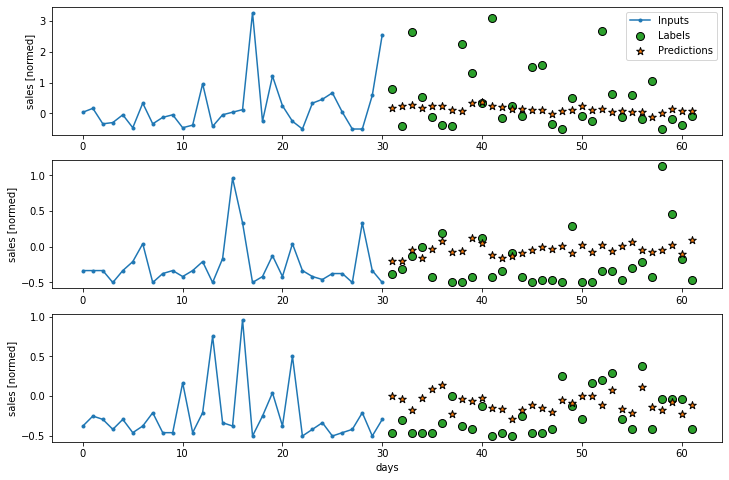

In [38]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

##CNN

753/753 [==============================] - 2s 3ms/step - loss: 0.5965 - root_mean_squared_error: 0.7723


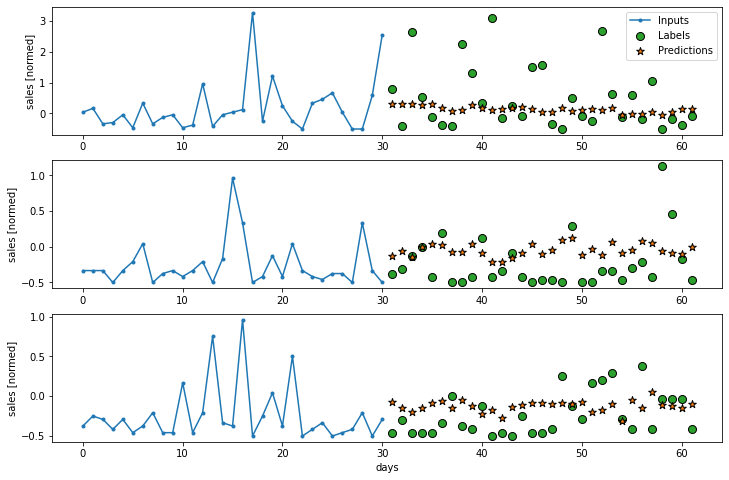

In [39]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(128, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

##RNN

753/753 [==============================] - 3s 4ms/step - loss: 0.7006 - root_mean_squared_error: 0.8370


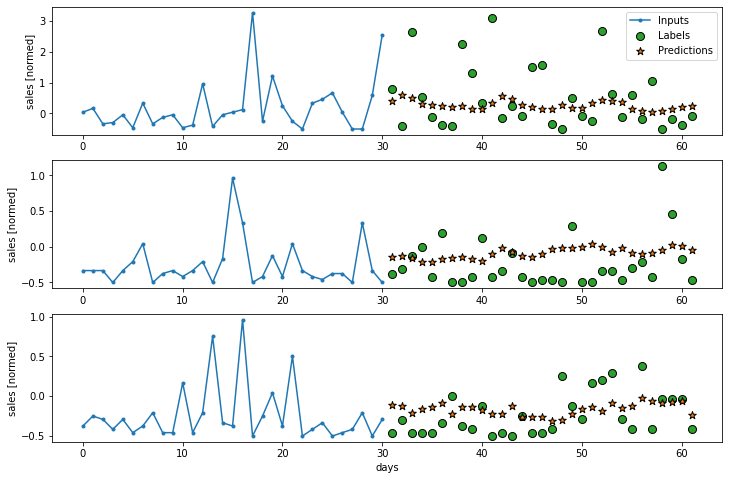

In [40]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(64, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

In [41]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [42]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [43]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

In [44]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([30, 6])

In [45]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the lstm state
  prediction, state = self.warmup(inputs)

  # Insert the first prediction
  predictions.append(prediction)

  # Run the rest of the prediction steps
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

In [46]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (30, 31, 6)


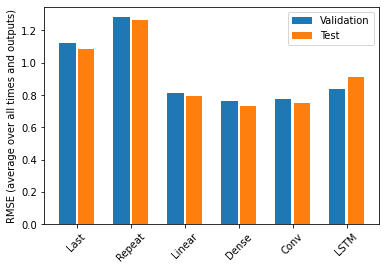

In [47]:
x = np.arange(len(multi_performance))
width = 0.3


metric_name = 'root_mean_squared_error'
metric_index = lstm_model.metrics_names.index('root_mean_squared_error')
val_rmse = [v[metric_index] for v in multi_val_performance.values()]
test_rmse = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_rmse, width, label='Validation')
plt.bar(x + 0.17, test_rmse, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'RMSE (average over all times and outputs)')
_ = plt.legend()

In [48]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Last    : 1.0863
Repeat  : 1.2661
Linear  : 0.7919
Dense   : 0.7334
Conv    : 0.7505
LSTM    : 0.9148


From the visualization and the average RMSE values, Dense and CNN are found to be most competitive ones for prediction.

## Test using test.csv:
Load the test.csv file and as the model is trained on windows, the test.csv would also be split into windows to be used in prediction.

In [49]:
#load data
test_csv_path = '/content/drive/MyDrive/Drug_sales/test_data.csv'

In [50]:
df_test = pd.read_csv(test_csv_path)
IDs = df_test.pop('id')
df_test.head()

,year,month,day,city,medicine
0,2018,7,1,1,1292
1,2018,7,1,1,1
2,2018,7,1,1,2
3,2018,7,1,1,3
4,2018,7,1,1,4


In [51]:
final_test = df_test/df_test.max()
final_test.head()

,year,month,day,city,medicine
0,1.0,1.0,0.032258,0.1,0.377447
1,1.0,1.0,0.032258,0.1,0.000292
2,1.0,1.0,0.032258,0.1,0.000584
3,1.0,1.0,0.032258,0.1,0.000876
4,1.0,1.0,0.032258,0.1,0.001169


In [105]:
w11 = WindowGenerator(input_width=31, label_width=31, shift=1)
w11

Total window size: 82
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81]
Label column name(s): None

Label column names is None, because we don't have any labels as we need to predict the sales for the test.csv dataset.

Here I have followed wide-window method for prediction in chunks followed by saving the result in a csv file.

In [119]:
predictions_norm = []
wide_window = WindowGenerator(
    input_width=4700, label_width=4700, shift=1)
for example_inputs1, example_labels1 in wide_window.train.take(1):
  predictions_norm.append(abs(dense.predict(example_inputs1)))

predictions = np.array(predictions_norm)
n= predictions.shape[0]*predictions.shape[1]*predictions.shape[2]*predictions.shape[3]
predictions1 = predictions.reshape((n,1))
print(predictions1)
final_predictions = (predictions1*train_std['sales']) + train_mean['sales'] 
final_predictions = final_predictions[:len(IDs)]

[[0.01754647]
 [1.7446665 ]
 [0.9464202 ]
 ...
 [0.09859344]
 [0.15071903]
 [0.54766566]]


In [128]:
dict_ofsubmission = {'sales':final_predictions}
submission_df = pd.DataFrame(data = final_predictions,index = None, columns = ['sales'])
submission_df.to_csv('submission_sales.csv')  
submission_df.head()

,sales
0,53.782745
1,218.977005
2,142.626953
3,130.796173
4,159.234650
